# LDA Topic Modeling


In [146]:
import nltk
import json
import string
import gensim
import matplotlib.pyplot as plt
import requests
import numpy as np
import pandas as pd


from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.matutils import corpus2csc
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn import cluster

# Charger les données

In [147]:
def getId(liste, page, header):
    """
    les id des decisions en rapport avec les universités
    """
    param = "query=universite%20&jurisdiction=cc&jurisdiction=ca&jurisdiction=tj&date_start=2021-01-01&date_end=2024-01-01&page_size=50&page="+str(page)

    response = requests.get("https://sandbox-api.piste.gouv.fr/cassation/judilibre/v1.0/search?"+param,
                            headers=header)

    if response.status_code == 200:
        data = response.json()
        for decision in data["results"]:
            liste.append(decision["id"])

header = {"accept": "application/json",
          "KeyId": "80f0270f-5e79-4685-abfb-cb2b92e0c24e"}
list_id = list()
page = 0
while page < 13:
    getId(list_id, page, header)
    page = page + 1
print("Nombre de id récupéré: ",len(list_id))

Nombre de id récupéré:  635


In [148]:
data = list()

def get_text(id):
    """
    Extraire le texte intégrale des décisions 
    """
    response = requests.get("https://sandbox-api.piste.gouv.fr/cassation/judilibre/v1.0/decision?id="+id, headers=header)

    if response.status_code == 200:
        d = response.json()
        data.append([d["text"]])

for id in list_id:
    get_text(id)


# Pré-traitement

In [154]:
# Miniscule
data = [[mot.lower() for mot in t] for t in data]

# Suppression des ponctuation 
data = ["".join([c for c in list(t) if not (c in list(string.punctuation))]) for t in data]

# Tokenisation
data_quote = [word_tokenize(text) for text in data]

# Lemmatisation
lem = WordNetLemmatizer()
data_lm = [[lem.lemmatize(word) for word in t] for t in data_quote]

In [155]:
# Stopwords
stop_words = stopwords.words("french")
stop_words.extend(["cette", "cour", "doit", "quil", "conclusion", "dune", "cassation", "euro", "larticle", "demande",
                   "somme", "monsieur", "fait", "jugement", "code", "titre", "travail", "procédure",
                   "être", "civile", "disposition", "contrat", "madame", "cause", "quelle", "sans", "dont", "dappel",
                   "droit", "décision", "date", "peut", "ainsi", "avoir", "droit", "nest", "mois", "septembre",
                   "charge", "octobre", "novembre", "janvier", "conseil", "demandes", "tribunal", "localité",
                   "plus", "alors", "juillet", "décembre", "préjudice", "salarié", "lemployeur", "deux", "tout",
                   "adresse", "juin", "licenciement", "février", "avril", "donc", "lors", "comme", "entre",
                   "après", "frais"])
data_sw = [[word for word in text if word not in stop_words] for text in data_lm]
print(data_sw[0])

['civ', '1', 'cf', 'audience', 'publique', '3', 'mar', '2021', 'rejet', 'mme', 'batut', 'président', 'arrêt', 'n°', '183', 'fsp', 'pourvoi', 'n°', 'k', '1922855', 'r', 'é', 'p', 'u', 'b', 'i', 'q', 'u', 'e', 'f', 'r', 'a', 'ç', 'a', 'i', 'e', 'nom', 'peuple', 'français', 'arrêt', 'première', 'chambre', '3', 'mar', '2021', 'h', 'dit', 'domicilié', 'a', 'formé', 'pourvoi', 'n°', 'k', '1922855', 'contre', 'larrêt', 'rendu', '28', 'mai', '2019', 'paris', 'pôle', '1chambre', '1', 'litige', 'lopposant', '1°', 'luniversité', 'siège', '2°', 'abou', 'dhabi', 'education', 'council', 'adec', 'siège', '3°', 'ministère', 'affaire', 'présidentielles', 'emirats', 'arabes', 'unis', 'pris', 'personne', 'ministre', 'affaire', 'présidentielles', 'ambassade', 'emirats', 'arabes', 'unis', 'france', 'siège', '4°', 'f', 'b', 'u', 'domicilié', 'défendeurs', 'demandeur', 'invoque', 'lappui', 'pourvoi', 'moyens', 'annexés', 'présent', 'arrêt', 'dossier', 'a', 'communiqué', 'procureur', 'général', 'rapport', 'fu

In [156]:

# On remarque beaucoup de lettre à 1 caractère, des suites d'underscores et de chiffres, on les enlève 

data_sw = [[word for word in text if not word.isdigit()] for text in data_sw]
data_sw = [[word for word in text if not "__" in word] for text in data_sw]
data_sw = [[word.replace("'", "") for word in text] for text in data_sw]
data_sw = [[word for word in text if len(word) >= 4] for text in data_sw]

print(data_sw[0])



['audience', 'publique', 'rejet', 'batut', 'président', 'arrêt', 'pourvoi', 'peuple', 'français', 'arrêt', 'première', 'chambre', 'domicilié', 'formé', 'pourvoi', 'contre', 'larrêt', 'rendu', 'paris', 'pôle', '1chambre', 'litige', 'lopposant', 'luniversité', 'siège', 'abou', 'dhabi', 'education', 'council', 'adec', 'siège', 'ministère', 'affaire', 'présidentielles', 'emirats', 'arabes', 'unis', 'pris', 'personne', 'ministre', 'affaire', 'présidentielles', 'ambassade', 'emirats', 'arabes', 'unis', 'france', 'siège', 'domicilié', 'défendeurs', 'demandeur', 'invoque', 'lappui', 'pourvoi', 'moyens', 'annexés', 'présent', 'arrêt', 'dossier', 'communiqué', 'procureur', 'général', 'rapport', 'fulchiron', 'conseiller', 'observation', 'baraduc', 'duhamel', 'rameix', 'avocat', 'piwnica', 'molinié', 'avocat', 'ministère', 'affaire', 'présidentielles', 'émirats', 'arabes', 'unis', 'lavis', 'carondéglise', 'avocat', 'général', 'débats', 'laudience', 'publique', 'présents', 'batut', 'président', 'fu

# Utilisation de Gensim 

In [157]:
dic = Dictionary(data_sw)
print(dic)
# Bag of word 
data_bow = [dic.doc2bow(text) for text in data_sw]


Dictionary<39770 unique tokens: ['1chambre', 'abou', 'absolue', 'accompli', 'accomplis']...>


In [163]:
# Technique LDA
lda = LdaModel(corpus=data_bow, id2word=dic,num_topics=10)
topic = lda.print_topics(num_words=20)
print(topic)

print(lda.get_term_topics("luniversité", minimum_probability=0))

# topic 1 et 4

[(0, '0.007*"société" + 0.003*"durée" + 0.003*"dépens" + 0.003*"party" + 0.003*"mise" + 0.003*"salaire" + 0.003*"lieu" + 0.003*"arrêt" + 0.002*"service" + 0.002*"motif" + 0.002*"heures" + 0.002*"condamner" + 0.002*"compte" + 0.002*"temp" + 0.002*"condition" + 0.002*"formation" + 0.002*"compter" + 0.002*"prudhommes" + 0.002*"serum" + 0.002*"éléments"'), (1, '0.008*"société" + 0.003*"party" + 0.003*"intérêts" + 0.003*"avocat" + 0.003*"application" + 0.002*"payer" + 0.002*"dépens" + 0.002*"salariée" + 0.002*"mise" + 0.002*"article" + 0.002*"motif" + 0.002*"barreau" + 0.002*"compter" + 0.002*"état" + 0.002*"condamner" + 0.002*"éléments" + 0.002*"chambre" + 0.002*"compte" + 0.002*"qualité" + 0.002*"président"'), (2, '0.006*"société" + 0.003*"compte" + 0.003*"twitter" + 0.003*"condition" + 0.003*"service" + 0.003*"juge" + 0.002*"dépens" + 0.002*"party" + 0.002*"clause" + 0.002*"condamner" + 0.002*"motif" + 0.002*"serum" + 0.002*"application" + 0.002*"intérêts" + 0.002*"avocat" + 0.002*"compt

In [164]:
topic_4= topic[1][1] 
print(topic_4)

topic_6= topic[4][1] 
print(topic_6)

0.008*"société" + 0.003*"party" + 0.003*"intérêts" + 0.003*"avocat" + 0.003*"application" + 0.002*"payer" + 0.002*"dépens" + 0.002*"salariée" + 0.002*"mise" + 0.002*"article" + 0.002*"motif" + 0.002*"barreau" + 0.002*"compter" + 0.002*"état" + 0.002*"condamner" + 0.002*"éléments" + 0.002*"chambre" + 0.002*"compte" + 0.002*"qualité" + 0.002*"président"
0.008*"société" + 0.003*"party" + 0.003*"serum" + 0.003*"dépens" + 0.003*"motif" + 0.003*"compter" + 0.003*"compte" + 0.002*"salaire" + 0.002*"application" + 0.002*"judiciaire" + 0.002*"intérêts" + 0.002*"condition" + 0.002*"condamner" + 0.002*"part" + 0.002*"avocat" + 0.002*"arrêt" + 0.002*"heures" + 0.002*"service" + 0.002*"formation" + 0.002*"article"


In [165]:
doc_topic = lda.get_document_topics(data_bow)
matrice = corpus2csc(doc_topic).T.toarray()
print(matrice) # dans le premier text le topic 1 est non nul

[[0.9960708  0.         0.         ... 0.         0.         0.        ]
 [0.0182179  0.         0.         ... 0.         0.         0.        ]
 [0.01014569 0.07064333 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.8349719  ... 0.         0.0244154  0.        ]
 [0.         0.         0.02004825 ... 0.         0.71906412 0.19366698]
 [0.94314438 0.         0.01451001 ... 0.         0.02298837 0.        ]]


# Clustering

## TF-IDF

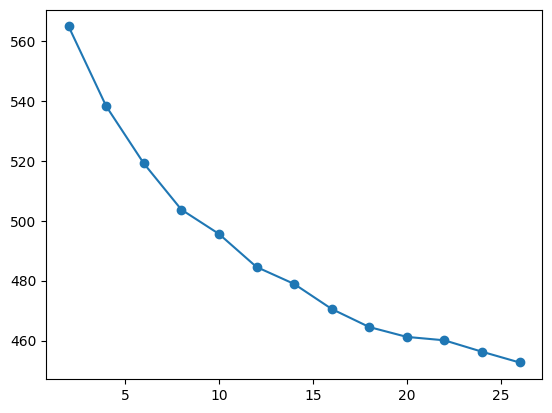

In [166]:
tfidf = TfidfVectorizer(
                        min_df = 5,
                        max_df = 0.95,
                       )

cleanData = [" ".join(t) for t in data_sw]

text = tfidf.fit_transform(cleanData)

def find_optimal_clusters(d, max_k):
    iters = range(2, max_k+1, 2)
    
    inertia = []
    for k in iters:
        kmeans = KMeans(n_clusters=k, random_state=20,).fit(d)
        inertia.append(kmeans.inertia_)      

    plt.plot(iters, inertia, marker='o')
    plt.show()

find_optimal_clusters(text, 26)


## Mots clés par cluster 

In [167]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            

clusters = MiniBatchKMeans(n_clusters=20, random_state=20).fit_predict(text)
get_top_keywords(text, clusters, tfidf.get_feature_names_out(), 10)





Cluster 0
condamner,liquidateur,arbitral,dépens,judiciaire,party,paris,commerce,sociétés,société

Cluster 1
lagent,moral,chance,expert,laccident,inexcusable,société,perte,docteur,détention

Cluster 2
liste,judiciaires,grief,expert,magistrats,générale,recours,langue,traduction,lassemblée

Cluster 3
naposa,daposune,laposarrêt,quaposelle,daposun,laposemployeur,daposappel,quaposen,laposarticle,quaposil

Cluster 4
diplômes,bordeaux,maîtrise,dancienneté,note,diplôme,emplois,syndicat,société,militaires

Cluster 5
résidence,lentrée,administrative,séjour,détention,placement,libertés,dasile,préfet,rétention

Cluster 6
cessionnaire,cession,légèreté,blâmable,jonquières,liquidation,liquidateur,soissons,société,valmet

Cluster 7
sérieuse,administrative,service,rappel,prime,support,salaire,fonctions,société,salariée

Cluster 8
pathologie,avis,professionnelle,professionnelles,régional,comité,caisse,malady,maladie,crrmp

Cluster 9
dommages,partenaires,reclassement,intérêts,prudhommes,réelle,sérieuse,s